In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as patheffects
import cmocean as cmo
import glob
import os

from tqdm import tqdm
from jax import grad, jit, vmap, jacfwd, jacrev, lax
from jax import random
from functools import partial
from scipy import optimize
from natsort import natsorted
mpl.style.use(['seaborn-v0_8-poster', 'seaborn-v0_8-muted'])

#betanalphas' colormap
colors = ["#DCBCBC","#C79999","#B97C7C","#A25050","#8F2727", "#7C0000","#DCBCBC20", "#8F272720","#00000060"]
color  = {i[0]:i[1] for i in zip(['light','light_highlight','mid','mid_highlight','dark','dark_highlight','light_trans','dark_trans','superfine'],colors)}
fancycolors = [mpl.colors.to_hex(c) for c in [[0.6, 0.6, 0.6],[0.7, 0.3, 1],[0.3, 0.7, 1],[0.2, 0.9, 0.9],
                                              [0.3, 1, 0.7],[0.7, 1, 0.3],[0.9, 0.9, 0.2],[1, 0.7, 0.3],[1, 0.3, 0.7],
                                              [0.9, 0.2, 0.9],[1.0, 1.0, 1.0]]]
threecolors = [mpl.colors.to_hex(c) for c in [[0.1, 0.15, 0.4],[1, 0.2, 0.25],[1.0, 0.775, 0.375]]]
fourcolors = [mpl.colors.to_hex(c) for c in [[0.9, 0.6, 0.3],[0.9, 0.4, 0.45],[0.5, 0.65, 0.75],[0.42, 0.42, 0.75]]]
def addtxt(ax, x, y, txt, fs=8, lw=3, clr='k', bclr='w', rot=0):
    """Add text to figure axis"""
    return ax.text(x, y, txt, color=clr, ha='left', transform=ax.transAxes, rotation=rot, weight='bold',
                   path_effects=[patheffects.withStroke(linewidth=lw, foreground=bclr)], fontsize=fs)
def hessian(f):
    """Returns a function which computes the Hessian of a function f
           if f(x) gives the values of the function at x, and J = hessian(f)
           J(x) gives the Hessian at x"""
    return jit(jacfwd(jacrev(f)))

For numerical convenience, we will work with the logarithm of the hyperparameters.
For example, for the Square Exponential kernel we have

\begin{align}
K(x_1,x_2) &= \gamma \exp{\left[-\frac{1}{2}\frac{(x_1-x_2)^2}{l^2}\right]} \\
&= \exp{\left[\log{\gamma} - \frac{1}{2} \left(e^{-\log{l}} (x_1-x_2)\right)^2\right]} \\
&= \exp{\left[\theta_0 - \frac{1}{2}\left(e^{-\theta_1} (x_1 - x_2)\right)^2\right]} \\
\Theta &= (\log{\gamma}, \log{l})
\end{align}

In [2]:
@jit
def K_OrnsteinUhlenbeck(x1, x2, θ):
    logγ, logl = θ
    return np.exp(logγ - 0.5*np.exp(-logl)*np.abs(x1-x2))

@jit
def K_Matern32(x1,x2,θ):
    logγ, logl = θ
    r = np.sqrt(3.0)*np.abs(x1-x2)*np.exp(-logl)
    return (1.0 + r)*np.exp(logγ-r)
@jit
def K_Matern52(x1,x2,θ):
    logγ, logl = θ
    r = np.sqrt(5.0)*np.abs(x1-x2)*np.exp(-logl)
    return (1.0 + r + (1.0/3.0)*r**2.0)*np.exp(logγ-r)
@jit
def K_Matern72(x1,x2,θ):
    logγ, logl = θ
    r = np.sqrt(7.0)*np.abs(x1-x2)*np.exp(-logl)
    return (1.0 + r + (2.0/5.0)*r**2.0 + (1.0/15.0)*r**3.0)*np.exp(logγ-r)
@jit
def K_SquareExp(x1,x2,θ):
    logγ, logl = θ
    return np.exp(logγ-0.5*((x1-x2)*np.exp(-logl))**2)
@jit
def K_NN(x0,x1,θ):
    σ0,σ = np.exp(θ)
    return 2.0/np.pi*np.arcsin(2.0*(σ0 + σ*x0*x1)/np.sqrt((1.0 + 2.0*(σ0 + σ*x0**2.0)) * (1.0 + 2.0*(σ0 + σ*x1**2))))

@jit 
def K_RQ(x1,x2,θ):
    γ, l, α = np.exp(2*θ)
    return γ*(1 + ((((x1-x2)/l)**2)/(2*α)))**(-α)

# broadcast a function of three variables variables f(a,b,θ), such that for x = [x1,...,xn] and y = [y1,...,ym]
# outermap(f)(x,y,θ) = [[f(x_1,y_1,θ), f(x_1,y_2,θ), ... , f(x_1,y_m,θ)],
#                       [f(x_2,y_1,θ), f(x_2,y_2,θ), ... , f(x_2,y_m,θ)],
#                       ...
#                       [f(x_n,y_1,θ), f(x_n,y_2,θ), ... , f(x_n,y_m,θ)]] 
outermap = lambda f : vmap(vmap(f, in_axes=(None,0,None)), in_axes=(0,None,None)) 

In [3]:
@jit
def logpGP(δf, Σ, ϵ):
    """Compute minus log-likelihood of observing δf = f - <f>, for GP with covariance matrix Σ"""
    n     = len(δf)
    noise = np.ones_like(δf)*ϵ   # jiggle parameter to improve numerical stability of cholesky decomposition
    L     = np.linalg.cholesky(Σ + np.diag(noise))
    v     = np.linalg.solve(L, δf)
    return (0.5*np.dot(v, v) + np.sum(np.log(np.diag(L))) + 0.5*n*np.log(2.0*np.pi))

@jit
def postGP(δfb, Kaa, Kab, Kbb):
    """Compute posterior average and covariance from conditional GP p(fa | xa, xb, fb)
    [fa,fb] ~ 𝒩([μ_fa, μ_fb], [[Kaa, Kab],[Kab^T, Kbb]])])
    fa|fb   ~ 𝒩(μf + Kab Kbb \ (fb - μ_fb) , Kaa - Kab Kbb \ Kab^T)
    """
    L = np.linalg.cholesky(Kbb)
    
    # α = K \ δ f = L^t \ (L | δ f)
    α = np.linalg.solve(L.transpose(), np.linalg.solve(L, δfb))
    
    # μpost - μ(x*) = Kab Kbb \ δf(x) = Kab . α
    μpost = np.dot(Kab, α)

    # Kpost = Kaa - Kab Kbb | Kab^T 
    #       = Kaa - W
    # W_ij  = v_i . v_j 
    # v_i   = (L | c_i) ; c_i the i-th column of Kba, i-th row of Kab
    V     = np.array([np.linalg.solve(L, c) for c in Kab]) # V = [v_1, v_2, ... ]^t
    Kpost = Kaa - np.einsum('ik,jk->ij',V,V)
    return μpost, Kpost # note should add μ(x*) to average

Let us try to infer the steady state 1D Stokes flow
\begin{align}
\frac{\text{d}^2 v}{\text{d} x^2} &= v_{xx} =  \Delta \widetilde{P} \Longrightarrow
\mathcal{L}_x v = \Delta\widetilde{P}\\
\mathcal{L} &\equiv \frac{\text{d}^2}{\text{d}x^2}\\
\Delta \widetilde{P} &= \frac{\Delta P}{\eta L}
\end{align}

with boundary conditions $v(x=0) = v_0$ and $v(x=1) = v_1$.

Placing a GP prior on $v$, the linearity of the Stokes equation leads to the following GP for the joint distribution of the velocity and its second derivatives

\begin{align}
\begin{pmatrix}v^\star \\ v \\ v_{xx}\end{pmatrix} &=
\mathcal{N}\left(\begin{bmatrix}\mu_{v^\star} \\ \mu_{v} \\ \mu_{v_{xx}}\end{bmatrix}, 
\begin{bmatrix} 
K^{v^\star, v^\star} & K^{v^\star, v} & K^{v^\star, v_{xx}} \\
& K^{v, v} & K^{v, v_{xx}} \\
& & K^{v_{xx}, v_{xx}}
\end{bmatrix}
\right)
\end{align}

As training points we have the values of the velocity $v$ and the second derivatives $\partial_{xx} v$ at some arbitrary positions, not necessarily the same for both. In particular, we will be interested in the case where the training points for the velocity are specified at the domain boundaries.

Given the linearity of the laplacian, the covariance Kernel can be written solely in terms of $K^{vv} = K$.

\begin{align}
\begin{pmatrix}v^\star \\ v \\ v_{xx}\end{pmatrix} &=
\mathcal{N}\left(\begin{bmatrix}\mu_{v^\star} \\ \mu_{v} \\ \mu_{v_{xx}}\end{bmatrix}, 
\begin{bmatrix} 
K(x^\star, x^\star) & K(x^\star, x) & \mathcal{L}_2 K(x^\star, x^f) \\
& K(x, x) & \mathcal{L}_2 K(x, x^f) \\
& & \mathcal{L}_1\mathcal{L}_2 K(x^f, x^f)
\end{bmatrix}
\right)
\end{align}

where $x^\star$, $x$, and $x^f$ are the locations of the velocity test points, velocity training points, and second derivative training points, respectively, and the subscript in $\mathcal{L}$ refers to which of the two arguments of the kernel function it is acting on.

In [4]:
@partial(jit, static_argnums=(4,5))
def mixedK(θ, x0, x1, x2, K01, K02):
    """Compute off diagonal block matrix [K(x*, x), L_2 K(x*, x')]
    Args :
      θ  : kernel hyperparamters
      x0 : test points for velocity
      x1 : training points for velocity (i.e., boundary points)
      x2 : trainnig points for forces
      K01: velocity/velocity covariance function = K_vv
      K02: velocity/force covariance function = L_2 K_vv
    Returns:
      off diagonal covariance matrix
    """
    n0,n1,n2 = len(x0), len(x1), len(x2)
    Σ = np.zeros((n0,n1+n2))
    Σ = Σ.at[:,:n1].set(K01(x0, x1, θ))
    Σ = Σ.at[:,n1:].set(K02(x0, x2, θ))
    return Σ
    
@partial(jit, static_argnums=(3,4,5))
def trainingK(θ, x1, x2, K11, K12, K22): 
    """Compute training block matrix 
    [[K(x,x)         L_2 K(x, xf)],         ->   [[ K11(x1,x1)    K12(x1, x2)
     [L_1 K(xf, x)   L_1 L_2 K(xf, xf)]]          [ K12(x1,x2)^T  K22(x2,x2)]
    Args :
      θ  : kernel hyperparameters
      x1 : training points for velocity (i.e., boundary points)
      x2 : training points for forces
      K11: velocity/velocity covariance function = K_vv
      K12: velocity/force covaraince function = L K_vv
      K22: force/force covariance function = L L K_vv
    Returns:
      training covariance matrix
    """
    n1,n2 = len(x1), len(x2)
    Σ = np.zeros((n1+n2,n1+n2))
    Σ = Σ.at[:n1, :n1].set(K11(x1, x1, θ))
    Σ = Σ.at[:n1, n1:].set(K12(x1, x2, θ))
    Σ = Σ.at[n1:, n1:].set(K22(x2, x2, θ))
    Σ = Σ.at[n1:, :n1].set(np.transpose(Σ[:n1, n1:]))
    return Σ

def flowGP(Kernel):
    """Generate functions used to compute log-likelihood (to be minimized) and prediction functions 
    Args :
      Kernel  : kernel function to use (RBF, NN, Matern, etc..), should be three paramters function k(x,x',θ) """
    L    = lambda f, i : grad(grad(f, i), i) # L = d^2 / dx^2
    _LK  = L(Kernel, 1)                      # (L_2 K)(x*,x')
    _LLK = L(_LK, 0)                         # (L_1 L_2 K)(x',x')

    K    = jit(outermap(Kernel))
    LK   = jit(outermap(_LK))
    LLK  = jit(outermap(_LLK))

    def trainingFunction(θ, *args):
        """Returns minus log-likelihood given Kernel hyperparamters θ and training data args
        args = velocity position, velocity average, velocity values, 
               force position, force average, force values, 
               jiggle parameter
        """
        xv, μv, yv, xf, μf, yf, ϵ = args        
        δy = np.concatenate([yv - μv, yf - μf]) # create single training array, with velocities and forces (second derivatives)
        Σ = trainingK(θ, xv, xf, K, LK, LLK)
        return logpGP(δy, Σ, ϵ)
    
    def predictingFunction(θ, *args):
        """Returns conditional posterior average and covariance matrix given Kernel hyperparamters θ  and test and training data
        args = test velocity position, test velocity average,
               training velocity position, training velocity average, training velocity values
               training force position, training force average, training force values
               jiggle parameter
        """
        xp, μp, xv, μv, yv, xf, μf, yf, ϵ = args
        nb  = len(xv) + len(xf)   # total number of training data points (velocity + forces) 
        Σbb = trainingK(θ, xv, xf, K, LK, LLK) + np.diag(np.ones(nb)*ϵ)
        Σab = mixedK(θ, xp, xv, xf, K, LK)
        Σaa = K(xp, xp, θ)
        μpost,Σpost = postGP(np.concatenate([yv-μv, yf-μf]), Σaa, Σab, Σbb)
        return μp + μpost, Σpost
    
    return jit(trainingFunction), jit(predictingFunction)

In [5]:
def optimizeParameters(f, df, hf, init, *args):
    def printer(o):
        print(f'\t loss = {o["fun"]:12.6e}, niter = {o["nit"]:5d}, Converged = {o["success"]:6b} : {o["message"]}')
        print(f'\t\t     θ0 = {np.exp(init)}')        
        print(f'\t\t      θ = {np.exp(o["x"])}')
        print(f'\t\t log(θ) = {o["x"]}')
        
    opt = {'maxiter':1000, 'disp':0}
    opt2= {'maxfun':1000, 'disp':0}
    res = [{'x':init}]
    xv, _, _, xf, *_ = args
    ntraining = len(xv) + len(xf)
    func  = lambda p,*args : f(p, *args)/ntraining**2
    dfunc = lambda p,*args : df(p,*args)/ntraining**2
    hess  = lambda p,*args : hf(p,*args)/ntraining**2  
    res.append(optimize.minimize(func, res[-1]['x'], args=args, method='Nelder-Mead', options=opt))
    res.append(optimize.minimize(func, res[-1]['x'], args=args, method='TNC', jac=dfunc,options=opt2))      
    res.append(optimize.minimize(func, res[-1]['x'], args=args, method='L-BFGS-B', options=opt))
    res.append(optimize.minimize(func, res[-1]['x'], args=args, method='BFGS', jac=dfunc,options=opt))  
    
    printer(res[-1])             
    return res

def solution(func, dfunc, hess, pred, init, *args):
    opt = optimizeParameters(func, dfunc, hess, init, *args[2:])
    θ0  = opt[-1]['x']
    v,Σ = pred(θ0, *args)
    dv  = np.sqrt(np.diag(Σ))
    print(f'\t max(σ_v) = {np.max(dv):.1e}')
    print(f'\n')
    return v, dv, opt[-1]

In [6]:
def initializer(*, 
                a_new_v, b_new_v, n_new_v,  
                a_obs_f, b_obs_f, n_obs_f, Δp,                
                a_obs_v, b_obs_v, va_obs, vb_obs,                
                fboundary,
                δ,
                ϵ):
    """
    Args:
    a_new_v, b_new_v, n_new_v: [a,b] limits for the n_new test points at which velocity will be computed
    a_obs_p, b_obs_p, n_obs_p, Δp    : [a,b] limits for (inner) n_obs training points at which forces (velocity second derivatives = Δp) are observed
    a_obs_v, b_obs_v, va_obs, vb_obs : xa,xb, v(xa), v(xb), are the observed values of velocity at boundaries 
    fboundary : true|false, whether or not to include boundary points in force training data
    δ : the offset by which to shrink the observation domain for the pressures, [a+δ, b+δ], so they don't necessarily fall on the boundary
    ϵ : the jiggle parameter to improve numerical stability of the Cholesky decomposition

    Returns:
        xnew_v, μnew_v, xobs_v, μobs_v, yobs_v, xobs_f, μobs_f, yobs_f, ϵ**2
    """
    if not fboundary:
        xobs_f = np.linspace(a_obs_f + δ, b_obs_f - δ, num=n_obs_f + 2)[1:-1] # remove boundaries
    else:
        xobs_f = np.linspace(a_obs_f + δ, b_obs_f - δ, num=n_obs_f)

    yobs_f  = np.ones_like(xobs_f)*Δp/(b_obs_f-a_obs_f)

    xobs_v = np.array([a_obs_v, b_obs_v])
    yobs_v = np.array([va_obs, vb_obs])

    xnew_v = np.linspace(a_new_v,b_new_v,num=n_new_v)
    
    # return argument list needed as input for GP functions
    return (xnew_v, np.zeros_like(xnew_v),          # x, μ
            xobs_v, np.zeros_like(yobs_v), yobs_v,  # x, μ, y
            xobs_f, np.zeros_like(yobs_f), yobs_f,  # x, μ, y
            ϵ**2)

In [7]:
logposterior = lambda loglikelihood : (lambda θ, *args : loglikelihood(θ, *args) + np.sum(θ)) # log posterior = log likelihood + log prior (using Jeffrey's prior)

loglikelihood_SE, predictor_SE = flowGP(K_SquareExp)
func_SE  = jit(logposterior(loglikelihood_SE))
dfunc_SE = jit(grad(func_SE))
hess_SE  = hessian(func_SE)

loglikelihood_RQ, predictor_RQ = flowGP(K_RQ)
func_RQ  = jit(logposterior(loglikelihood_RQ))
dfunc_RQ = jit(grad(func_RQ))
hess_RQ  = hessian(func_RQ)

loglikelihood_MT, predictor_MT, = flowGP(K_Matern52)
func_MT  = jit(logposterior(loglikelihood_MT))
dfunc_MT = jit(grad(func_MT))
hess_MT  = hessian(func_MT)

loglikelihood_NN, predictor_NN = flowGP(K_NN)
func_NN  = jit(logposterior(loglikelihood_NN))
dfunc_NN = jit(grad(func_NN))
hess_NN  = hessian(func_NN)

In [8]:
os.makedirs('./data', exist_ok=True)
    
def scan_solver(ftag,func, dfunc, hess, predictor,*,init,L, Δp, n_obs, x_obs, v_obs, n_new, x_new,δ,ϵ):
    solutions  = []
    frc_points = []
    opts       = [{'x':init}]
    for nob in n_obs:
        print(nob)
        args  = initializer(a_new_v = x_new[0], b_new_v =x_new[1], n_new_v= n_new,
                            a_obs_f = x_obs[0], b_obs_f =x_obs[1], n_obs_f= nob, Δp = Δp, 
                            a_obs_v = x_obs[0], b_obs_v =x_obs[1], va_obs = v_obs[0], vb_obs=v_obs[1], 
                            fboundary = False, δ = δ, ϵ = ϵ)
        frc_points.append(args[5])
        ans = solution(func, dfunc, hess, predictor, opts[-1]['x'], *args)
        if ans[2]['success']: # append solution if converged, use as initial guess for next iteration
            opts.append(ans[-1])
        solutions.append(ans)    

        vtest_points , _, _, _, _, _ , *_  = args # velocity test and training points are always the same

    df    = pd.DataFrame({'x':vtest_points}) # location of velocity test points
    for i,num in enumerate(n_obs):
        df[f'v_{num}'] = solutions[i][0]     # prediciton for velocity test points
        df[f'dv_{num}']= solutions[i][1]     # uncertainty for velocity test points               
        
    
    # Save data to file to avoid re-running calculations                 
    for i,nob in enumerate(n_obs):
        df_ft = pd.DataFrame({'x':frc_points[i]}) # location of force training points
        df_ft.to_csv(f'./data/{ftag}_ft_n{nob}.txt', sep = ' ', float_format = "%20.15e")    
    df.to_csv(f'./data/{ftag}.txt', sep = ' ', float_format = "%20.15e")

    return {'train':frc_points, 'test':df}

In [9]:
tags = {'se':'Squared Exponential', 'rq':'Rational Quadratic', 'nn':'Neural Network'} # 'mt':'Matern'
# Load data from file
def load_solution(ftag):
    frc_points = []
    for i,nob in enumerate(n_obs):
        frc_points.append(np.array(pd.read_csv(f'./data/{ftag}_ft_n{nob}.txt', delim_whitespace=True)['x'].to_numpy()))

    df = pd.read_csv(f'./data/{ftag}.txt', delim_whitespace=True)
    return {'train':frc_points, 'test':df}

In [10]:
os.makedirs('./fig_stokes', exist_ok=True)
def savefig(fig, name, **kargs):
    fig.savefig(f'./fig_stokes/{name}.png', **kargs)
    fig.savefig(f'./fig_stokes/{name}.pdf', **kargs)

# Couette Flow

In [11]:
L,Δp        = 1.0, 0.0, 
x_obs,v_obs = np.array([0.0, L]), np.array([-1.0, 1.0])
n_obs       = [1, 2, 3, 4, 5, 6, 8, 16, 32, 64]         # number of force training/observation points in [0,L]

x_new   = np.array([0.0, L])
n_new   = 20
couette = {}

In [12]:
couette['se'] = scan_solver('couette_se', func_SE, dfunc_SE, hess_SE, predictor_SE, init = np.array([0.0, 1.0]),
                            L=L, Δp=Δp, n_obs=n_obs, x_obs=x_obs, v_obs=v_obs, n_new=n_new, x_new=x_new, δ=0.0, ϵ=1e-4)

1
	 loss = 5.021133e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1.         2.71828183]
		      θ = [0.42406735 0.41745986]
		 log(θ) = [-0.85786298 -0.87356687]
	 max(σ_v) = 2.0e-01


2
	 loss = 4.803529e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.42406735 0.41745986]
		      θ = [0.41529072 0.41434446]
		 log(θ) = [-0.87877648 -0.88105763]
	 max(σ_v) = 6.4e-02


3
	 loss = 1.377700e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.41529072 0.41434446]
		      θ = [269.0774582   13.05320475]
		 log(θ) = [5.59499929 2.56903368]
	 max(σ_v) = 1.0e-04


4
	 loss = -1.199561e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [269.0774582   13.05320475]
		      θ = [363.19659449  15.16533871]
		 log(θ) = [5.89494427 2.71901248]
	 max(σ_v) = 1.0e-04


5
	 loss = -2.499334e-01, niter =     0, Converged =      1 : O

In [13]:
#couette['mt'] = scan_solver('couette_mt', func_MT, dfunc_MT, hess_MT, predictor_MT, init = np.array([0.0, 0.0]),
#                            L=L, Δp=Δp, n_obs=n_obs, x_obs=x_obs, v_obs=v_obs, n_new=n_new, x_new=x_new, δ=0.0, ϵ=1e-4)

In [14]:
couette['rq'] = scan_solver('couette_rq', func_RQ, dfunc_RQ, hess_RQ, predictor_RQ, init = np.array([0.0, 0.0, 1.0]),
                            L=L, Δp=Δp, n_obs=n_obs, x_obs=x_obs, v_obs=v_obs, n_new=n_new, x_new=x_new, δ=0.0, ϵ=1e-4)

1
	 loss = 6.671454e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1.         1.         2.71828183]
		      θ = [0.90963211 0.78321108 1.16640849]
		 log(θ) = [-0.09471503 -0.24435304  0.15392936]
	 max(σ_v) = 1.9e-01


2
	 loss = 3.605679e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.90963211 0.78321108 1.16640849]
		      θ = [152.01601072  12.38056087   1.35360743]
		 log(θ) = [5.02398585 2.51612757 0.3027732 ]
	 max(σ_v) = 1.0e-04


3
	 loss = -8.061971e-02, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [152.01601072  12.38056087   1.35360743]
		      θ = [186.18868132  13.70164987   1.3534604 ]
		 log(θ) = [5.22676058 2.61751625 0.30266457]
	 max(σ_v) = 1.0e-04


4
	 loss = -2.774113e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [186.18868132  13.70164987   1.3534604 ]
		      θ = [209.39286778  14.530378

In [15]:
couette['nn'] = scan_solver('couette_nn', func_NN, dfunc_NN, hess_NN, predictor_NN, init = np.array([0.0, 1.0]),
                            L=L, Δp=Δp, n_obs=n_obs, x_obs=x_obs, v_obs=v_obs, n_new=n_new, x_new=x_new, δ=0.0, ϵ=1e-4)

1
	 loss = 8.443732e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1.         2.71828183]
		      θ = [0.59309038 1.22997457]
		 log(θ) = [-0.52240849  0.20699349]
	 max(σ_v) = 4.3e-02


2
	 loss = 6.487557e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.59309038 1.22997457]
		      θ = [1.02723981 1.45255805]
		 log(θ) = [0.0268754  0.37332617]
	 max(σ_v) = 1.8e-02


3
	 loss = 4.666584e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1.02723981 1.45255805]
		      θ = [1.11781061 1.05048403]
		 log(θ) = [0.11137196 0.04925104]
	 max(σ_v) = 4.1e-03


4
	 loss = 3.517821e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1.11781061 1.05048403]
		      θ = [1.31203744 0.9772815 ]
		 log(θ) = [ 0.27158123 -0.02298054]
	 max(σ_v) = 1.4e-03


5
	 loss = 2.327306e-01, niter =     0, Converged =      1 : Optimization te

In [16]:
def plot_solution(ans, name, inum, stag='se'):
    fig, [ax,bx] = plt.subplots(figsize=(9,12),nrows=2, sharex=True)
    ii = inum
    ni = n_obs[ii]; print(f'(Force) Training Points = {ni}')

    for lbl, clr in zip(ans.keys(), [color['dark_highlight'], color['mid_highlight'], color['light_highlight'], color['light']]):
        df = ans[lbl]['test']
        x, v, dv = df['x'].values, df[f'v_{ni}'].values, df[f'dv_{ni}'].values
        ax.plot(x, v, color=clr, label=tags[lbl])
        ax.fill_between(x, v-2*dv, v+2*dv, color=clr, alpha=0.8)
        ax.plot(x, v, color=clr)

    xf = ans['se']['train']
    shift = (np.max(v)-np.min(v))*0.1
    ax.plot(x_obs, v_obs, ls='None', marker='o', color=color['superfine'], label='Training Velocity')    
    ax.plot(xf[ii], np.min(v)*np.ones_like(xf[ii]) - shift, ls='None', marker='s',mew = 3, mec=color['superfine'],
            ms=12, label='Training Force Location', mfc='None')
    ax.plot(x, vgold, ls='--', color=color['superfine'])
    ax.set_ylabel(r'${v}$', fontsize=22)
    ax.legend(loc=2, fontsize=15)

    ### 
    lbl  = tags[stag]
    df   = ans[stag]['test']
    clrs = [color['light'], color['mid'], color['dark']]
    dclrs= [color['light_highlight'], color['mid_highlight'], color['dark_highlight']]
    for i,ni in enumerate(n_obs[:3]):
        clr,dclr= clrs[i], dclrs[i]
        v,dv = df[f'v_{ni}'].values, df[f'dv_{ni}'].values
        bx.fill_between(x, v-2*dv, v+2*dv, color=clr, zorder=i,alpha=0.9, label=f'$n_f = {ni}$')
        bx.plot(x, v, color=dclr, zorder=50+2*i, lw=1)#, label=f'$n_f = {ni}$')
        bx.plot(xf[i], np.min(v)*np.ones_like(xf[i])-shift, ls='None', marker='s',mew = 4, mec=clr,
                ms=16-5*i, mfc='None')
    bx.plot(x_obs, v_obs, ls='None', marker='o', color=color['superfine'])    
    bx.plot(x, vgold, ls='--', color=color['superfine'],zorder=50, lw=3)
    bx.legend(fontsize=16)
    bx.set_ylabel(r'${v}$', fontsize=22)
    bx.set_xlabel(r'${x}$', fontsize=22)
    addtxt(bx, 0.05, 0.92, lbl, fs=14)
    savefig(fig, name, dpi=300, bbox_inches='tight')
    plt.show()

(Force) Training Points = 4


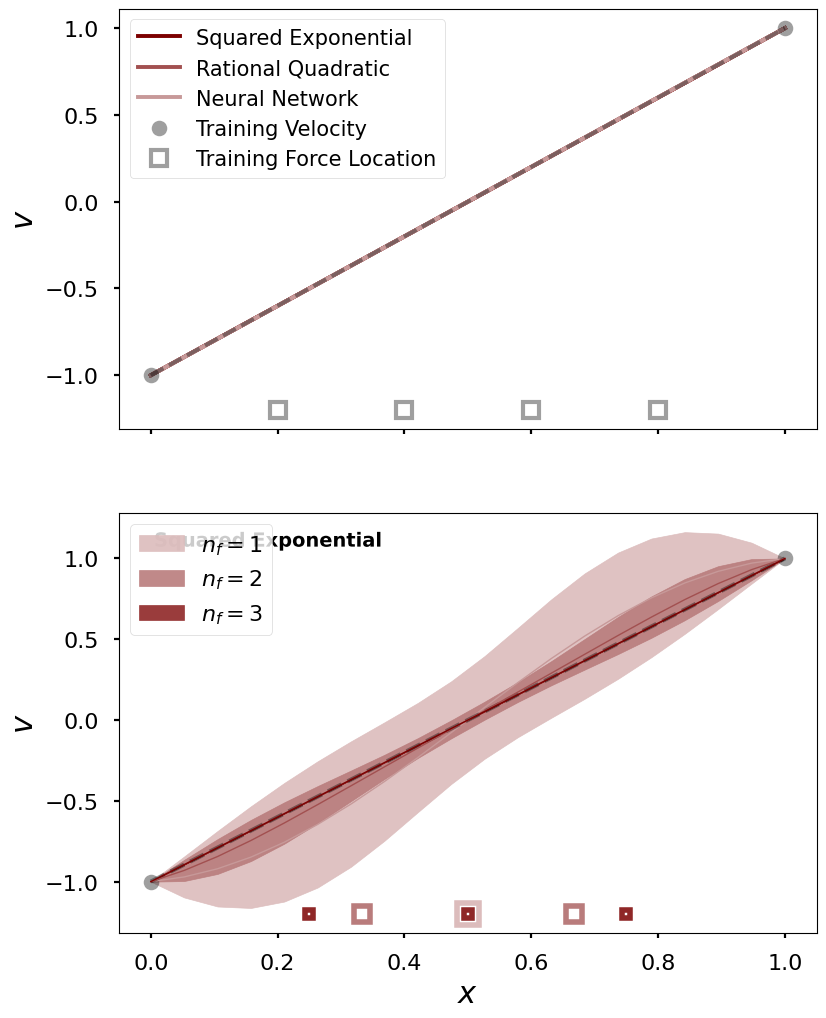

In [17]:
# reload from disk
couette = {tag : load_solution(f'couette_{tag}') for tag in tags.keys()}
vgold   = (lambda x :(v_obs[1]-v_obs[0])/L*x + v_obs[0])(couette['se']['test']['x'].values)
plot_solution(couette, 'couette', 3)

In [18]:
def plot_error(ans, name):
    fig, axes = plt.subplots(figsize=(9,8), ncols=2, nrows=2,sharex=True, sharey=True)
    for ax,lbl in zip(axes.flatten(), ans.keys()):
        df   = ans[lbl]['test']
        clrs = cmo.cm.haline(np.linspace(0, 1, num=len(n_obs)))
        for i, n in enumerate(n_obs):
            x = df['x'].values
            v = df[f'v_{n}'].values
            dv= df[f'dv_{n}'].values
            ax.plot(x,  np.abs(vgold - v), color=clrs[i])
            addtxt(ax, 0.1, 0.05, tags[lbl], fs=15)
    for ax in axes[1]:
        ax.set_xlabel(r'${x}$', fontsize=22)
    fig.suptitle('Absolute Error', fontsize=22)
    ax.semilogy()
    ax.set_ylim(1e-12,1e-0)
#    ax.set_xlim(0,1)
    fig.tight_layout()
    savefig(fig, 'name', dpi=300, bbox_inches='tight')
    plt.show()

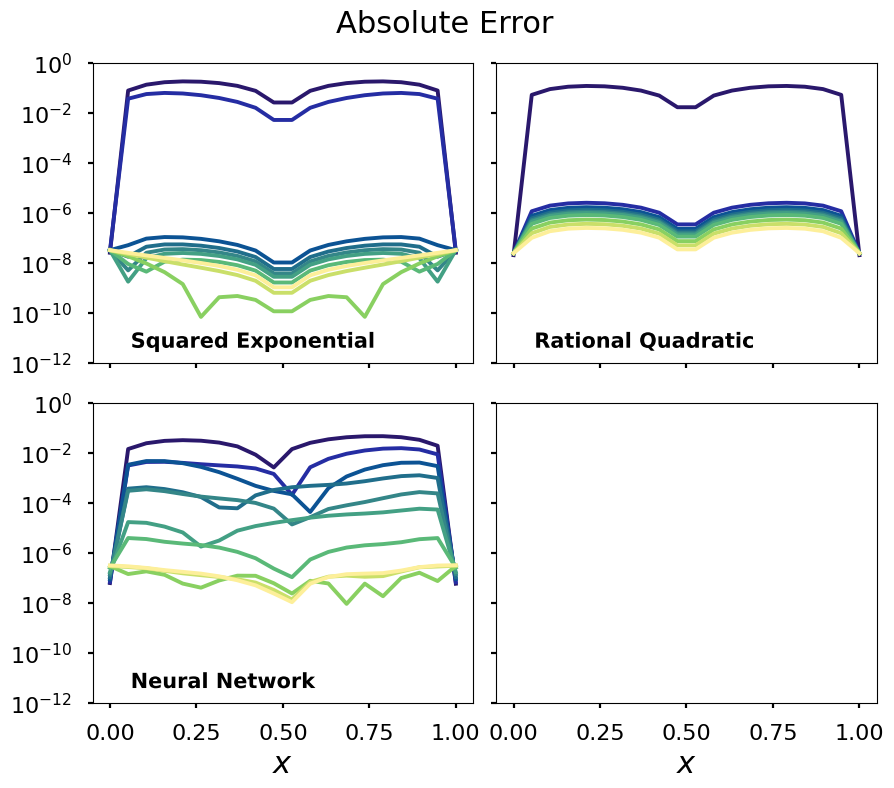

In [19]:
plot_error(couette, 'couette_error')

In [20]:
couette_epsilon = []
tols  = [5e-6, 5e-5, 5e-4, 5e-3, 5e-2]
tolbls = ['$5\cdot 10^{-6}$', '$5\cdot 10^{-5}$', '$5\cdot 10^{-4}$', '$5\cdot 10^{-3}$', '$5\cdot 10^{-2}$']
for eps in tols:
    print(eps)
    ergs  = initializer(a_new_v =x_new[0], b_new_v=x_new[1], n_new_v = n_new,
                        a_obs_f =x_obs[0], b_obs_f=x_obs[1], n_obs_f = 6, Δp =Δp,
                        a_obs_v =x_obs[0], b_obs_v=x_obs[1], va_obs=v_obs[0], vb_obs =v_obs[1], 
                        fboundary = False, δ = 0.00, ϵ = eps)
    couette_epsilon.append(solution(func_SE, dfunc_SE, hess_SE, predictor_SE, np.ones(2), *ergs))

5e-06
	 loss = -4.881973e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [2.71828183 2.71828183]
		      θ = [3594.56639608   47.71189135]
		 log(θ) = [8.18717865 3.86518066]
	 max(σ_v) = 5.0e-06


5e-05
	 loss = -3.562812e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [2.71828183 2.71828183]
		      θ = [774.71136711  22.14972598]
		 log(θ) = [6.65249053 3.09782513]
	 max(σ_v) = 5.0e-05


0.0005
	 loss = -2.243758e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [2.71828183 2.71828183]
		      θ = [167.40487776  10.29458462]
		 log(θ) = [5.1204153  2.33161799]
	 max(σ_v) = 5.0e-04


0.005
	 loss = -9.252344e-02, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [2.71828183 2.71828183]
		      θ = [36.55483153  4.80748192]
		 log(θ) = [3.59881337 1.57017344]
	 max(σ_v) = 5.0e-03


0.05
	 loss = 3.875757e-02, niter =     0, 

In [21]:
def plot_eps(ans, args, name):
    x , _, xt, _, yt, _ , *_  = args
    fig, [ax,bx] = plt.subplots(figsize=(9,9), nrows=2, sharex=True)
    clrs = mpl.cm.viridis(np.linspace(0, 0.8, num=len(ans)))
    yloc = [0.1, 0.25, 0.4, 0.6, 0.75]
    for i, [v,dv,*_] in enumerate(ans):
        bx.plot(x, np.abs(vgold - v), color=clrs[i], lw=4)
        addtxt(ax,0.85, 0.15+0.17*i, tolbls[i], clr=clrs[i], fs=16)
        ax.plot(x, dv, color=clrs[i])
        ax.hlines(tols[i], 0, 1, color=clrs[i], ls='--')
    addtxt(ax, 0.8, 0.15+0.17*0, '$\epsilon =$', clr=clrs[0], fs=16)
    ax.set_title('Prediction Uncertainty', fontsize=22)
    bx.set_title('Absolute Error', fontsize=22)
    bx.set_xlabel(r'${x}$', fontsize=22)
    ax.semilogy()
    bx.semilogy()
    bx.set_ylim(1e-12,1e-0)
    ax.set_ylim(1e-6,1e-0)
    ax.set_xlim(0,1)
    fig.tight_layout()
    savefig(fig, name, dpi=300, bbox_inches='tight')
    plt.show()

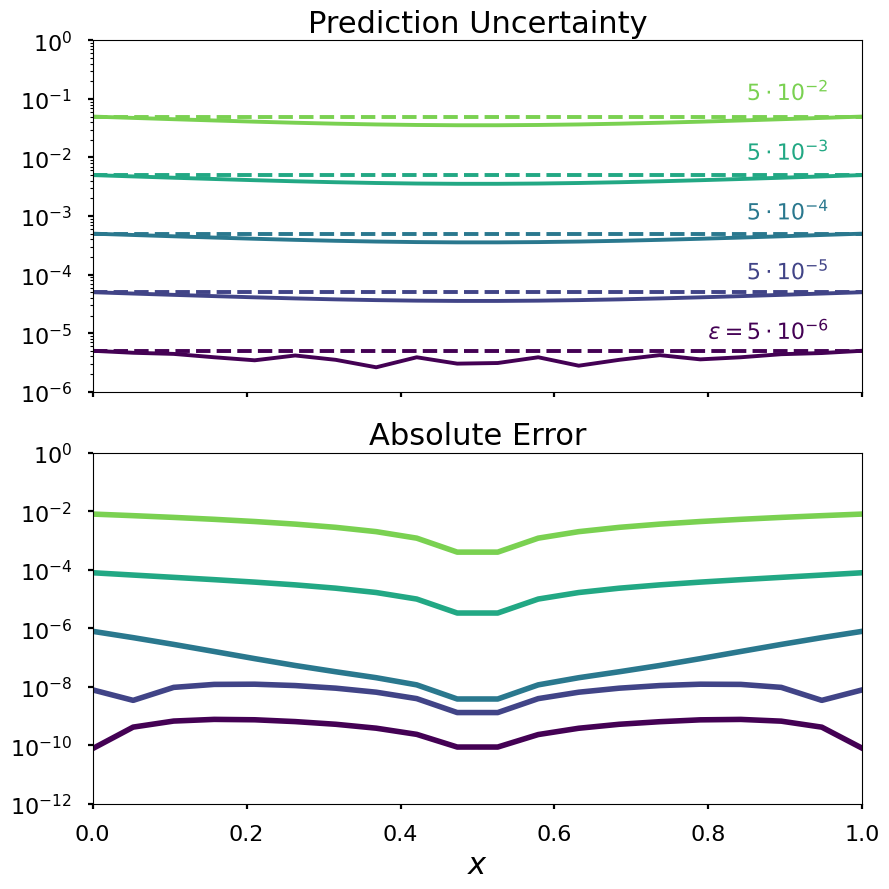

In [22]:
plot_eps(couette_epsilon, ergs, 'couette_eps')

# Poisieulle Flow

In [23]:
L,Δp        = 1.0, -1.0,
n_obs       = [3, 4, 5, 6, 8, 16, 32, 64]         # number of force training/observation points in [0,L]
x_obs,v_obs = np.array([0.0, L]), np.array([0.0, 0.0])

n_new = 20
x_new = np.array([0.0, L])
poiseuille = {}

In [24]:
poiseuille['se'] = scan_solver('poiseuille_se', func_SE, dfunc_SE, hess_SE, predictor_SE, init=np.array([0, np.log(L/2)]), 
                               L=L, Δp=Δp, n_obs=n_obs, x_obs=x_obs, v_obs=v_obs, n_new=n_new, x_new=x_new, δ=0.0, ϵ=1e-4)

3
	 loss = -2.021622e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1.  0.5]
		      θ = [0.00250612 0.27191722]
		 log(θ) = [-5.9890198 -1.3022576]
	 max(σ_v) = 7.4e-03


4
	 loss = -1.082194e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.00250612 0.27191722]
		      θ = [0.00414285 0.34459861]
		 log(θ) = [-5.48637105 -1.06537498]
	 max(σ_v) = 1.9e-03


5
	 loss = -4.588795e-02, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.00414285 0.34459861]
		      θ = [0.00585371 0.33705016]
		 log(θ) = [-5.14067923 -1.0875235 ]
	 max(σ_v) = 9.4e-04


6
	 loss = -1.999766e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.00585371 0.33705016]
		      θ = [23.94324713  3.13064445]
		 log(θ) = [3.17568633 1.14123888]
	 max(σ_v) = 1.0e-04


8
	 loss = -2.816474e-01, niter =     0, Converged =      1 : Optimization terminate

In [25]:
poiseuille['rq'] = scan_solver('poiseuille_rq', func_RQ, dfunc_RQ, hess_RQ, predictor_RQ, init=np.array([0.0, np.log(L/2), 1.0]), 
                               L=L, Δp=Δp, n_obs=n_obs, x_obs=x_obs, v_obs=v_obs, n_new=n_new, x_new=x_new, δ=0.0, ϵ=1e-4)

3
	 loss = -2.201249e+01, niter =     0, Converged =      0 : NaN result encountered.
		     θ0 = [1.         0.5        2.71828183]
		      θ = [2.02182847e-095 6.99119015e+014 1.57718741e-154]
		 log(θ) = [-218.04158155   34.18084211 -354.14246118]
	 max(σ_v) = 2.0e-95


4
	 loss = 1.070017e-02, niter =     0, Converged =      0 : Desired error not necessarily achieved due to precision loss.
		     θ0 = [1.         0.5        2.71828183]
		      θ = [11.16071273  2.44336425  1.31168484]
		 log(θ) = [2.41239982 0.89337588 0.27131244]
	 max(σ_v) = 1.0e-04


5
	 loss = -1.417653e-01, niter =     1, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1.         0.5        2.71828183]
		      θ = [16.40976522  2.69158086  1.30497517]
		 log(θ) = [2.7978766  0.9901287  0.26618402]
	 max(σ_v) = 1.0e-04


6
	 loss = -2.280252e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [16.40976522  2.69158086  1.30497517]
		      θ = [20.224

In [26]:
#poiseuille['mt'] = scan_solver('poiseuille_mt', func_MT, dfunc_MT, hess_MT, predictor_MT, init=np.array([-1.0, np.log(L)]), 
#                               L=L, Δp=Δp, n_obs=n_obs, x_obs=x_obs, v_obs=v_obs, n_new=n_new, x_new=x_new, δ=0.0, ϵ=1e-4)

In [27]:
poiseuille['nn'] = scan_solver('poiseuille_nn', func_NN, dfunc_NN, hess_NN, predictor_NN, init=np.array([-1.0, np.log(L)]), 
                               L=L, Δp=Δp, n_obs=n_obs, x_obs=x_obs, v_obs=v_obs, n_new=n_new, x_new=x_new, δ=0.0, ϵ=1e-4)

3
	 loss = 1.737306e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.36787944 1.        ]
		      θ = [0.65179323 0.84702341]
		 log(θ) = [-0.42802789 -0.16602694]
	 max(σ_v) = 2.8e-03


4
	 loss = 1.015513e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.65179323 0.84702341]
		      θ = [1.35951446 0.63797562]
		 log(θ) = [ 0.30712762 -0.44945521]
	 max(σ_v) = 5.4e-04


5
	 loss = 6.655569e-02, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1.35951446 0.63797562]
		      θ = [2.34603119 0.66579459]
		 log(θ) = [ 0.85272504 -0.40677408]
	 max(σ_v) = 2.1e-04


6
	 loss = 4.484470e-04, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [2.34603119 0.66579459]
		      θ = [2.68693659 0.58022755]
		 log(θ) = [ 0.98840173 -0.54433492]
	 max(σ_v) = 1.0e-04


8
	 loss = -8.617880e-02, niter =     0, Converged =      1 : Optimizati

- Best results are obtained for Squared-Exponential and Neural-Network
- Rational quadratic is ok...
- Note the poor convergence of the Matern Kernel in this case, $7/2$ is not bad (not great), $5/2$ is quite bad and $3/2$ never converges.

In [28]:
poiseuille = {tag : load_solution(f'poiseuille_{tag}') for tag in tags.keys()}
vgold      = (lambda x :-0.5/L*x*(x-L))(poiseuille['se']['test']['x'].values)

(Force) Training Points = 6


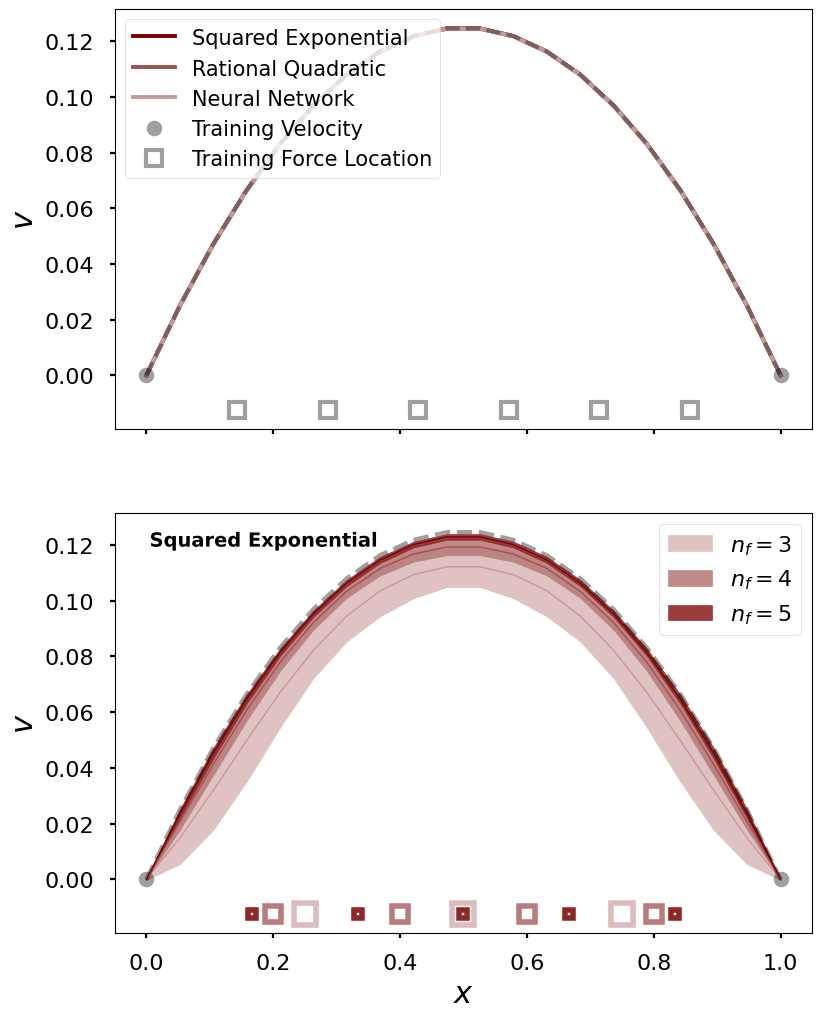

In [29]:
plot_solution(poiseuille, 'poiseuille', 3)

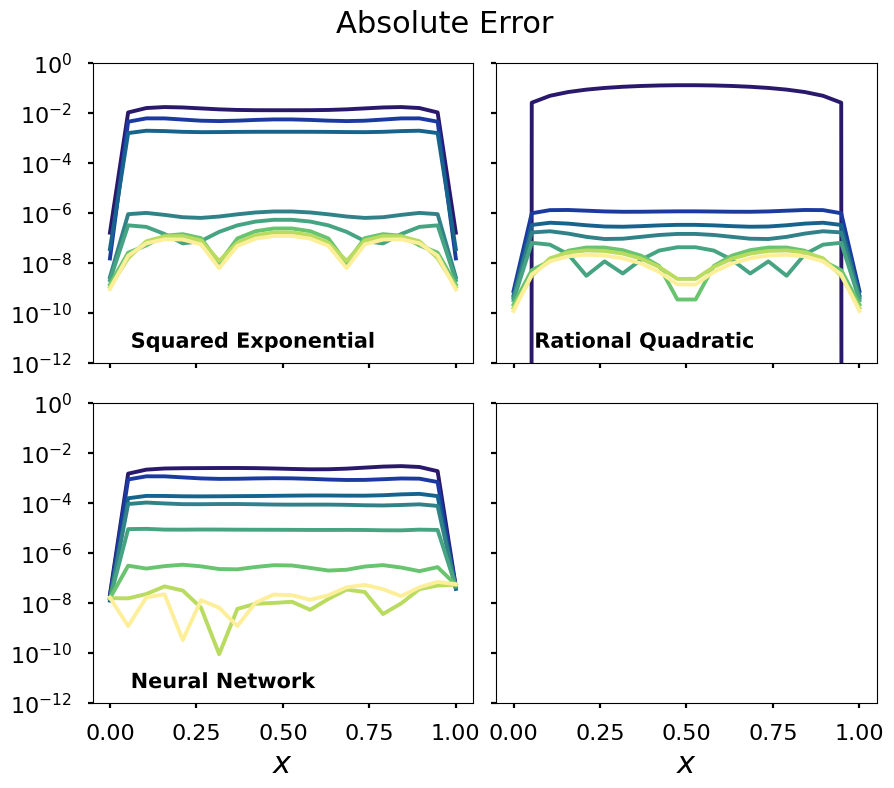

In [30]:
plot_error(poiseuille, 'poiseuille_error')

In [31]:
poiseuille_epsilon = []
tols = [5e-6, 5e-5, 5e-4, 5e-3, 5e-2]
tolbls = ['$5\cdot 10^{-6}$', '$5\cdot 10^{-5}$', '$5\cdot 10^{-4}$', '$5\cdot 10^{-3}$', '$5\cdot 10^{-2}$']
for eps in tols:
    print(eps)
    ergs  = initializer(a_new_v =x_new[0], b_new_v =x_new[1], n_new_v = n_new,
                        a_obs_f =x_obs[0], b_obs_f=x_obs[1],  n_obs_f = 6, Δp =Δp, 
                        a_obs_v =x_obs[0], b_obs_v=x_obs[1], va_obs=v_obs[0], vb_obs =v_obs[1],
                        fboundary = False, δ = 0.00, ϵ = eps)
    poiseuille_epsilon.append(solution(func_SE, dfunc_SE, hess_SE, predictor_SE, np.array([-1.0, np.log(L/4)]), *ergs))

5e-06
	 loss = -2.697484e-01, niter =     0, Converged =      0 : Desired error not necessarily achieved due to precision loss.
		     θ0 = [0.36787944 0.25      ]
		      θ = [495.13144906   6.67573583]
		 log(θ) = [6.20482328 1.89847943]
	 max(σ_v) = 5.0e-06


5e-05
	 loss = -2.160542e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.36787944 0.25      ]
		      θ = [48.47235166  3.73422466]
		 log(θ) = [3.88099357 1.31754021]
	 max(σ_v) = 5.0e-05


0.0005
	 loss = -1.629840e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.36787944 0.25      ]
		      θ = [4.5633155  2.06888652]
		 log(θ) = [1.51804944 0.72701055]
	 max(σ_v) = 5.0e-04


0.005
	 loss = -1.120564e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [0.36787944 0.25      ]
		      θ = [0.39167225 1.12128266]
		 log(θ) = [-0.93732988  0.11447326]
	 max(σ_v) = 5.0e-03


0.05
	 loss = -6.625139e-02

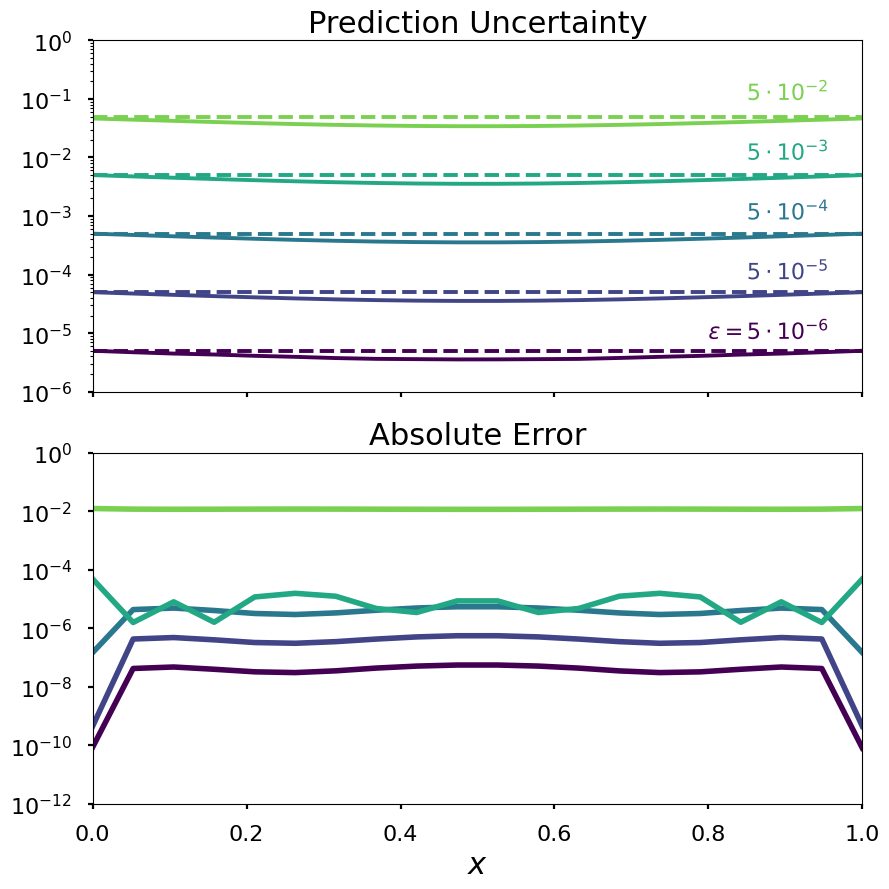

In [32]:
plot_eps(poiseuille_epsilon, ergs, 'poiseuille_eps')

# Poiseuille Extrapolation

In [33]:
def poisy(name, x_new_v, x_obs_v, x_obs_f, ntest, ntrain, dp, ntrace = 30):
    def d2fd(x, f):
        dx = x[1]-x[0]
        d2f = np.roll(f, -2) + np.roll(f, 2) - 2.0*f
        return d2f/(4*dx**2)
    key   = random.PRNGKey(0)    
    v_obs = np.array([0.0, 0.0])
    Δp=dp*(x_obs_f[1]-x_obs_f[0])
    args  = initializer(a_new_v = x_new_v[0], b_new_v = x_new_v[1], n_new_v = ntest,
                        a_obs_f = x_obs_f[0], b_obs_f = x_obs_f[1], n_obs_f = ntrain, Δp = Δp,
                        a_obs_v = x_obs_v[0], b_obs_v = x_obs_v[1], va_obs= v_obs[0], vb_obs=v_obs[1],
                        fboundary = False, δ = 0.0, ϵ = 1e-4)
    v,dv,opt = solution(func_SE, dfunc_SE, hess_SE, predictor_SE, np.array([0.0, 0.0]), *args)
    μ,Σ  = predictor_SE(opt['x'], *args)
    vrnd = μ + np.einsum('ij,...j->...i', np.linalg.cholesky(Σ + np.diag(np.ones_like(μ)*1e-10)), random.normal(key, (ntrace,) + μ.shape))    
    
    xv, _, _, _, _, xf, *_ = args
    lbox  = x_obs_v[1]-x_obs_v[0]
    vgold = (lambda x :-0.5/lbox*x*(x-lbox))(xv)

    
    fig, [ax,bx] = plt.subplots(figsize=(18,12),nrows=2,sharex=True)
    ax.fill_between(xv, v-2*dv, v+2*dv, color=color['mid'], lw=4)
    ax.plot(xv, v, color=color['dark_highlight'], lw=4.0)
    ax.plot(xv, vgold, color=color['superfine'], ls='--', lw=4)
    ax.plot(x_obs, v_obs, marker='o', color=color['superfine'], ls='None', ms=16)
    ax.plot(xf, np.min(vgold)*np.ones_like(xf), marker='x', mfc='None', ls='None', mew=2, color='k')    

    
    bx.plot(xf, np.ones_like(xf)*dp, marker='x', mfc='None', ls='None', mew=4, color='k')    
    for i in range(ntrace):
        ax.plot(xv,vrnd[i],lw=0.5,color=color['dark'])    
        fchck= d2fd(xv, vrnd[i])
        bx.plot(xv[2:-2], fchck[2:-2], color=color['dark'], lw=0.5)
    fchck = d2fd(xv, μ)
    bx.plot(xv[2:-2], fchck[2:-2], color=color['dark_highlight'], lw=4.0)
    bx.plot(xv, np.ones_like(xv)*dp, color=color['superfine'], ls='--',lw=4)
        
    ax.set_ylabel(r'$v$', fontsize=18)
    bx.set_ylabel(r'$\mathrm{d}^2 v / \mathrm{d}x^2$', fontsize=18)
    bx.set_xlabel(r'$x$', fontsize=18)

    fig.tight_layout()    
    savefig(fig, name, dpi=300, bbox_inches='tight')


	 loss = -1.082194e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1. 1.]
		      θ = [0.00414293 0.3446005 ]
		 log(θ) = [-5.48635104 -1.0653695 ]
	 max(σ_v) = 6.4e-02




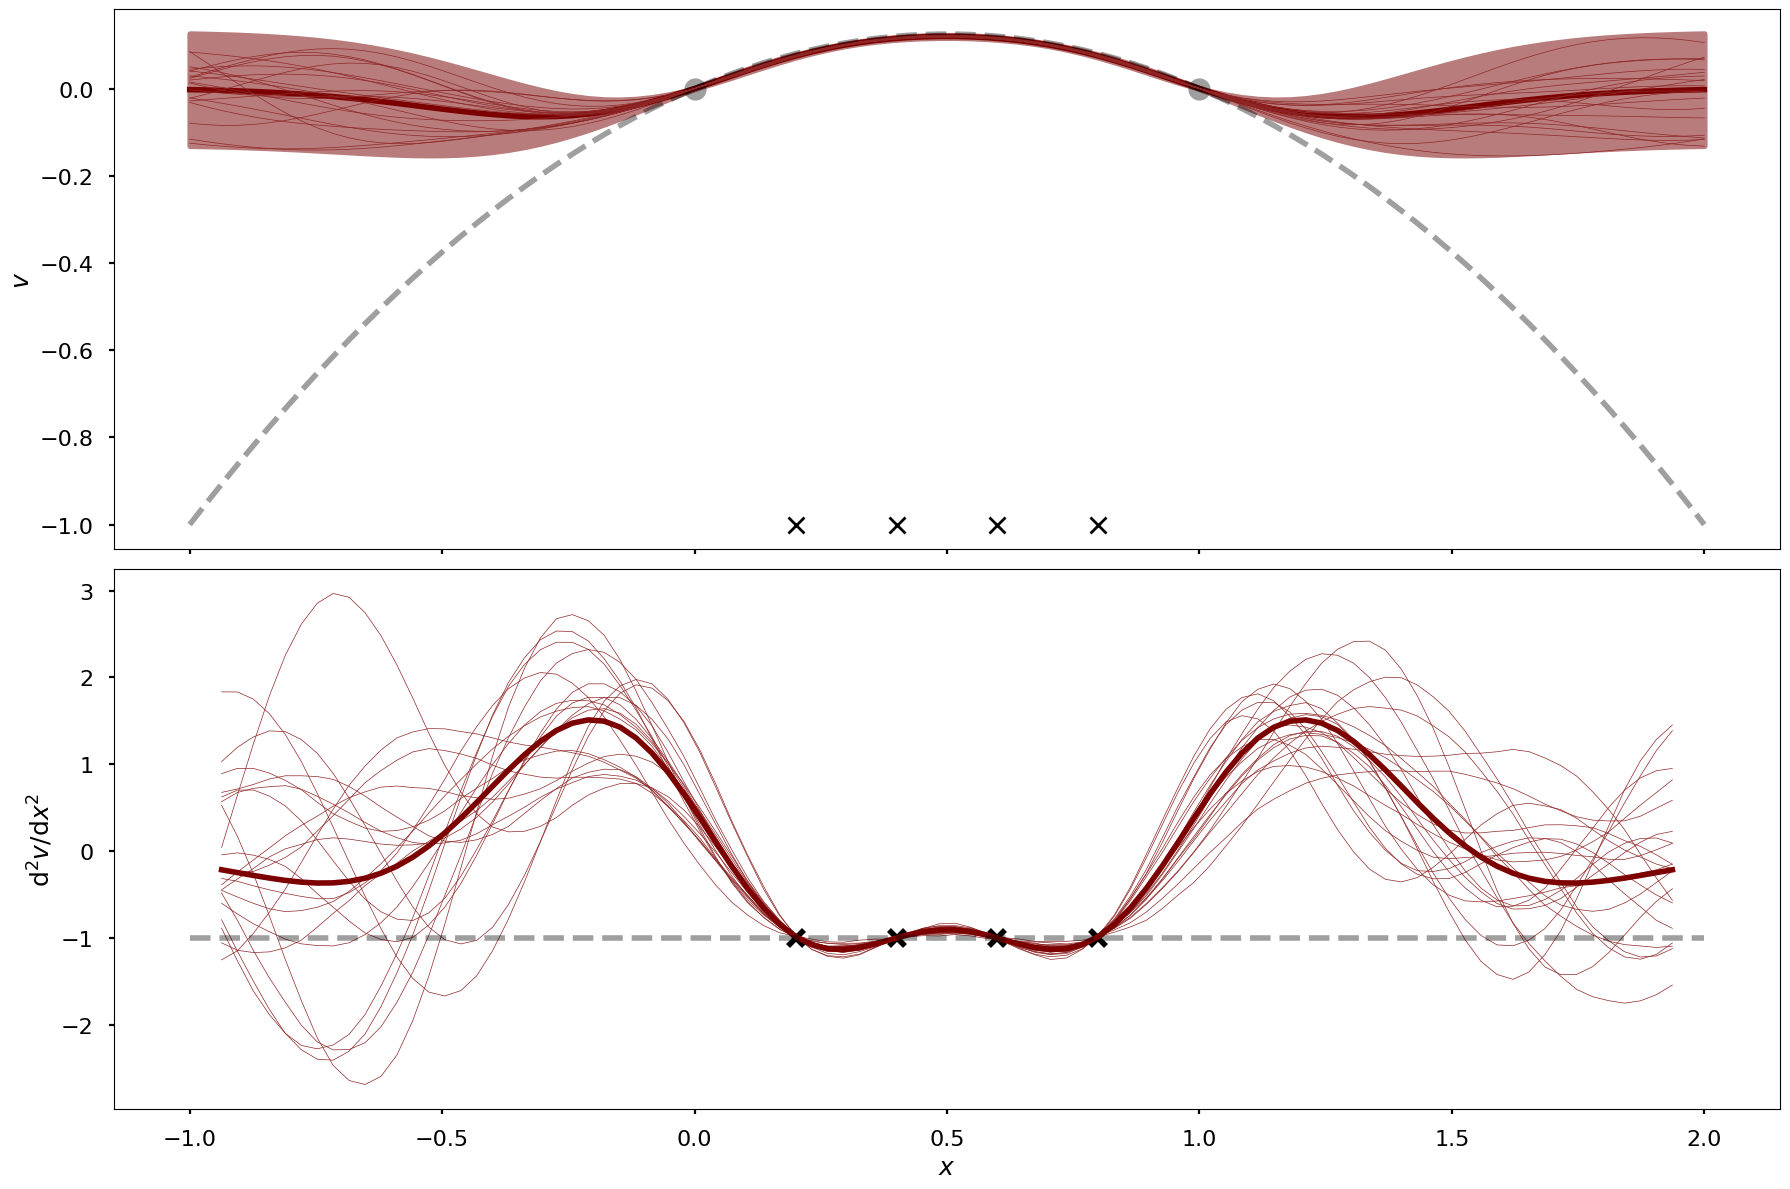

In [34]:
poisy('poiseuille_4inside', [-1, 2],[0, 1], [0,1], 96, 4, -1.0, 20)
plt.show()

	 loss = 1.928563e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1. 1.]
		      θ = [0.44362065 0.94338177]
		 log(θ) = [-0.81278546 -0.05828423]
	 max(σ_v) = 2.0e-02




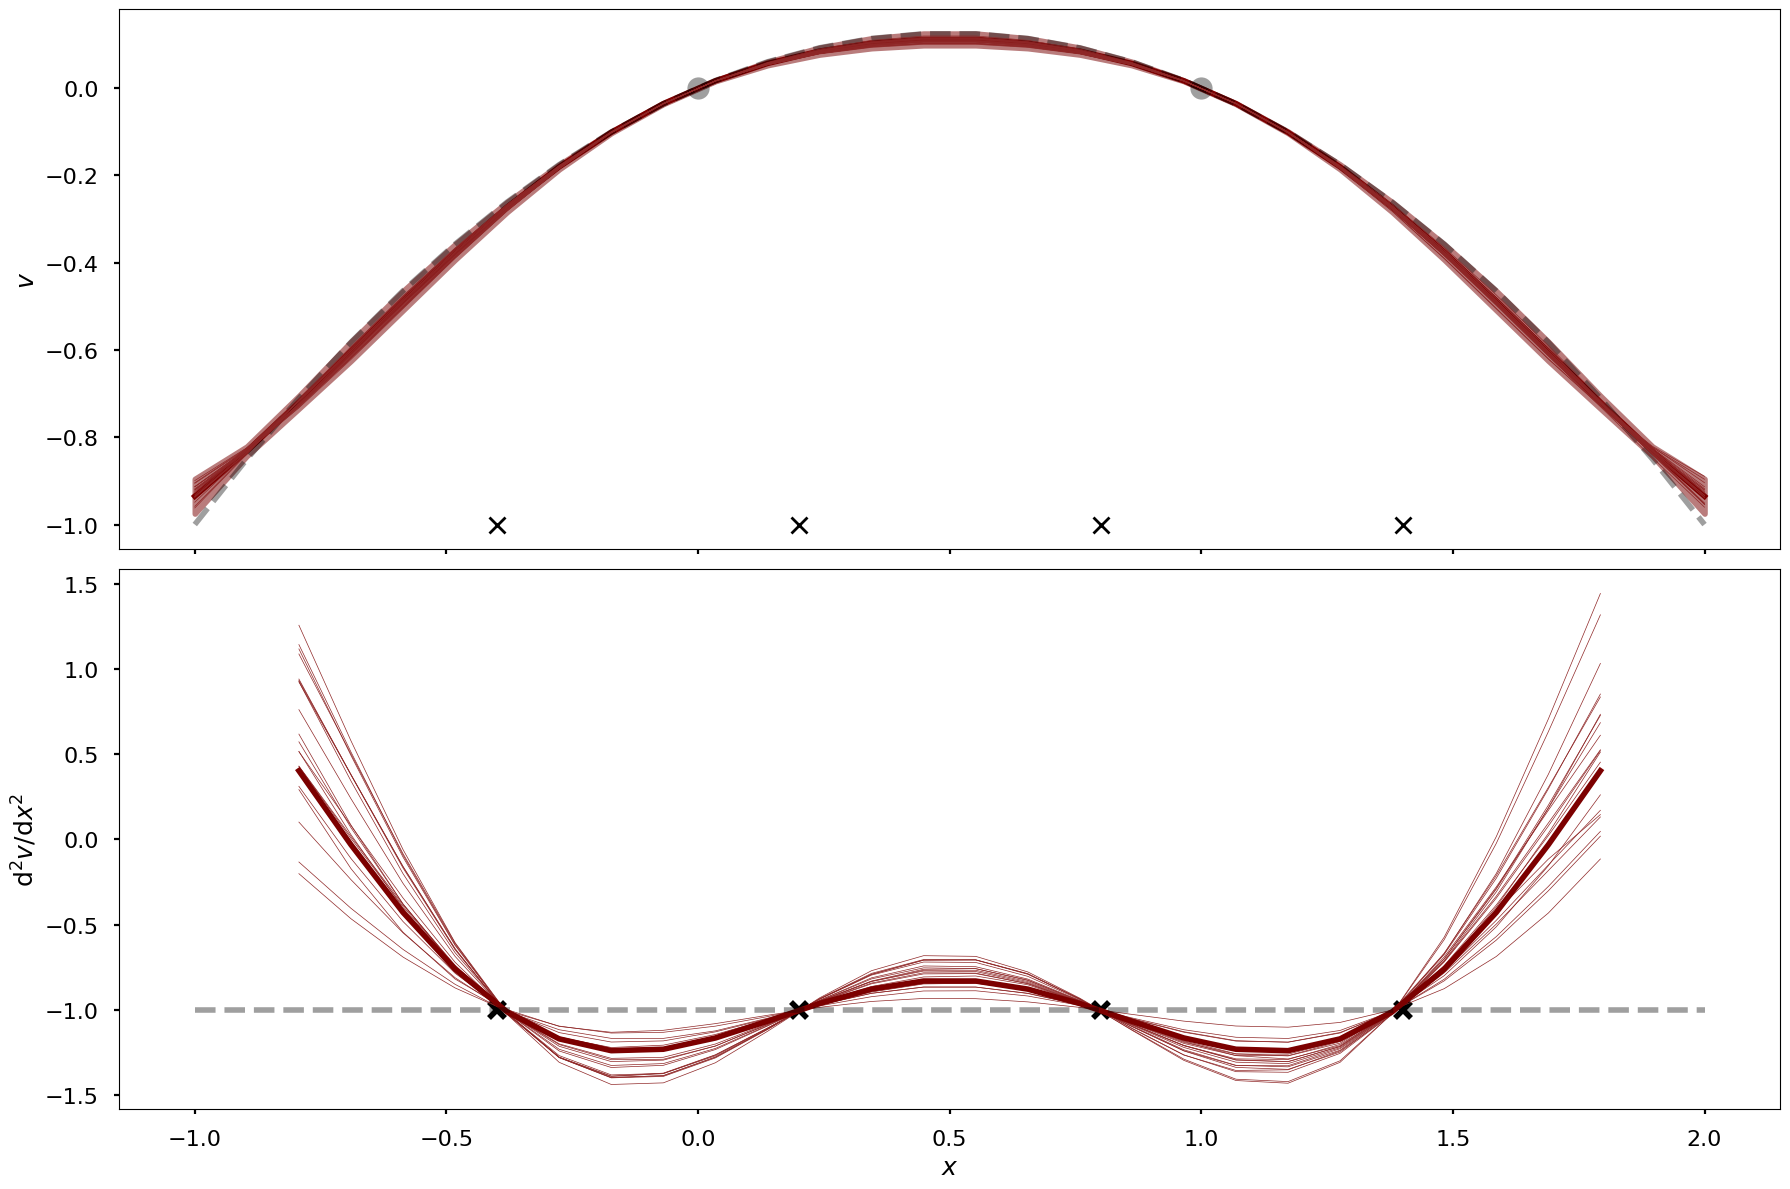

In [35]:
poisy('poiseuille_4inout',[-1, 2],[0, 1], [-1,2], 30, 4, -1.0, 20)
plt.show()

	 loss = -1.933173e-01, niter =     0, Converged =      1 : Optimization terminated successfully.
		     θ0 = [1. 1.]
		      θ = [3473.73473219   10.82972321]
		 log(θ) = [8.15298559 2.3822945 ]
	 max(σ_v) = 2.3e-04




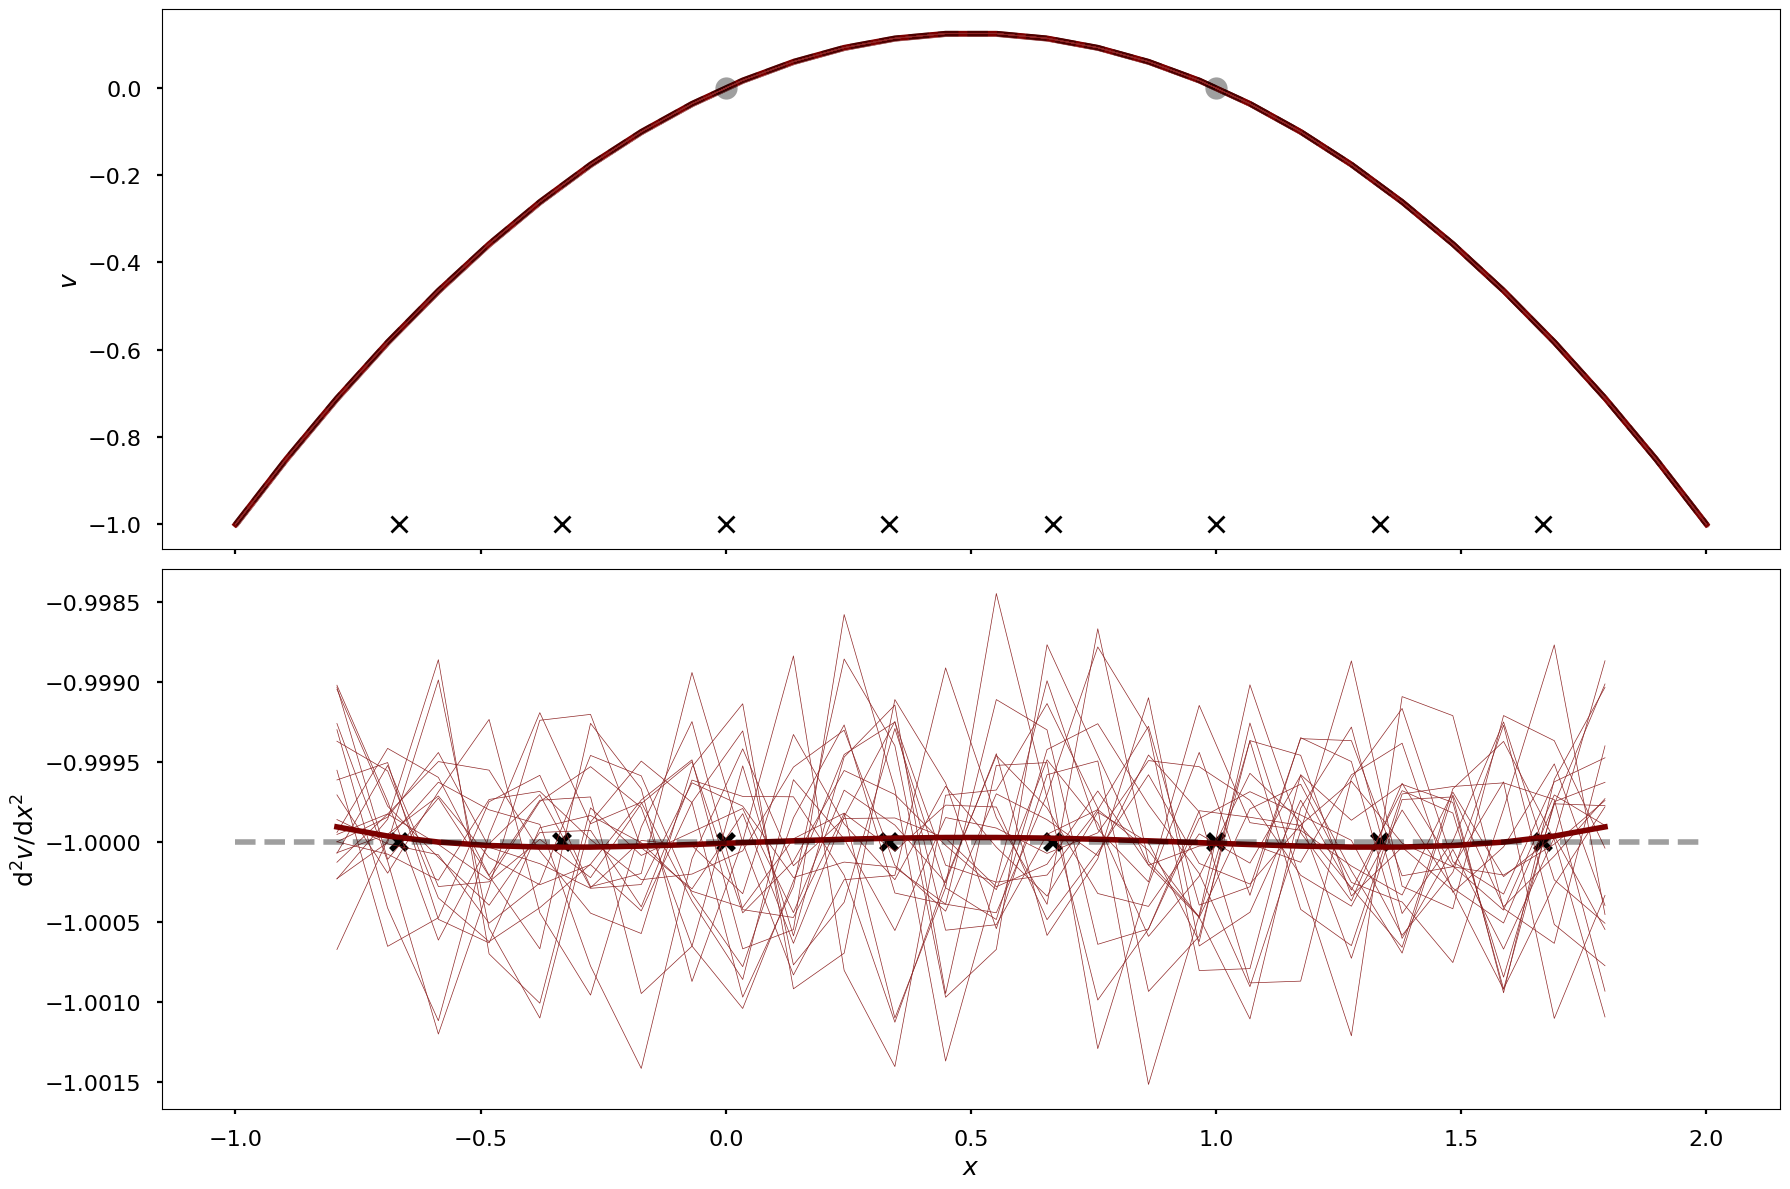

In [36]:
poisy('poiseuille_8inout',[-1, 2],[0, 1], [-1,2], 30, 8, -1.0, 20)
plt.show()